## Notebook 1: Data Preparation for CS230 Project using Dask and Pandas

First, load 10GB TSV file as Dask Dataframe

In [7]:
import dask.dataframe as dd 
import dask.array as da 
from dask.distributed import Client 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
#df = dd.read_hdf('rest_choice.h5','/data')
df = dd.read_csv("/home/groups/athey/store-visits/data/choicesDateSorted.tsv",parse_dates=["week","day"],sep="\t",dtype={'rating_in_sample':'float64'})
df.head()

,item_id,session_id,assignment,user_id,chosen,distance,week,day,rating_in_sample,rating_in_sample_missing,...,category__himalayan,category__waffles,category__russian,category__indonesian,category__dancerestaurants,factor(pricerange)1,factor(pricerange)2,factor(pricerange)3,factor(pricerange)4,factor(pricerange)NA
0,1003,100262,tr,8600,0,0.190,2017-01-02 08:00:00,2017-01-02 08:00:00,2.917,0,...,0,0,0,0,0,1,0,0,0,0
1,1008,100262,tr,8600,0,5.688,2017-01-02 08:00:00,2017-01-02 08:00:00,3.333,0,...,0,0,0,0,0,0,1,0,0,0
2,1014,100262,tr,8600,0,0.781,2017-01-02 08:00:00,2017-01-02 08:00:00,2.765,0,...,0,0,0,0,0,0,1,0,0,0
3,1029,100262,tr,8600,0,0.430,2017-01-02 08:00:00,2017-01-02 08:00:00,4.000,0,...,0,0,0,0,0,1,0,0,0,0
4,1035,100262,tr,8600,0,5.218,2017-01-02 08:00:00,2017-01-02 08:00:00,3.579,0,...,0,0,0,0,0,0,1,0,0,0


## 1. Plots and Summary Statistics about Chosen Restaurants

In [4]:
chosen = df[df['chosen']>0].persist() 

In [5]:
print("Latest day: ",chosen.day.max().compute())
print("Earliest day: ",chosen.day.min().compute())
print("Average Rating: ", chosen.rating_in_sample.mean().compute())
print("Average Distance: ",chosen.distance.mean().compute())
print("How many ratings imputed?: ", chosen.rating_in_sample_missing.sum().compute())

Latest day:  2017-10-31 07:00:00
Earliest day:  2017-01-02 08:00:00
Average Rating:  3.291987354184708
Average Distance:  2.006539414701238
How many ratings imputed?:  8261


#### Histograms of distances and ratings

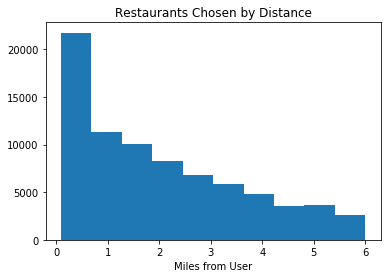

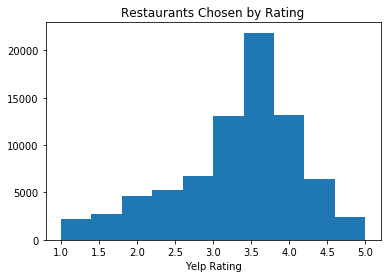

In [21]:
plt.figure() 
distanceSum = chosen.distance.compute() 
distanceSum.hist()
plt.xlabel('Miles from User')
plt.title('Restaurants Chosen by Distance')
plt.grid()
plt.savefig('distances_hist.png')

plt.figure() 
ratingSum = chosen.rating_in_sample.compute()
ratingSum.hist()
plt.xlabel('Yelp Rating')
plt.title('Restaurants Chosen by Rating')
plt.grid()
plt.savefig('ratings_hist.png')



#### Time Series Plots

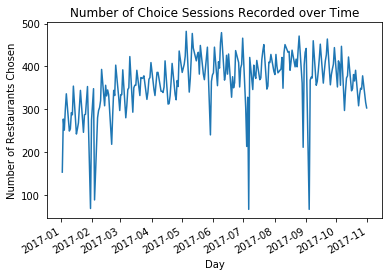

In [27]:
plt.figure() 
byDay = chosen.groupby(['day']).chosen.sum()
byDay.compute().plot()
plt.xlabel("Day")
plt.ylabel("Number of Restaurants Chosen")
plt.title("Number of Choice Sessions Recorded over Time")
plt.savefig("countsessions.png")
##sportsByDay = chosen.groupby(['day']).category__sportsbars.sum() 
#plt.figure() 
#chineseByDay.compute().plot() 
#plt.figure() 
#sportsByDay.compute().plot() 

#plt.figure() 
#chosen.groupby(['day']).category__bars.sum().compute().plot() 


## 2. Save data as HDF5 for Estimation in PyTorch

In [3]:
#re-index sessions, restaurants, and users for easier model computation 
sessions = df['session_id'].drop_duplicates().compute() 
session_idx_df = pd.DataFrame({'session_id': sessions,'session_idx':range(len(sessions))})
session_idx_df.index = session_idx_df['session_idx'].values
session_idx_df.head()

users = df['user_id'].drop_duplicates().compute() 
user_idx_df = pd.DataFrame({'user_id': users,'user_idx':range(len(users))})
user_idx_df.index = user_idx_df['user_idx'].values
user_idx_df.head()

items = df['item_id'].drop_duplicates().compute() 
item_idx_df = pd.DataFrame({'item_id': items,'item_idx':range(len(items))})
item_idx_df.index = item_idx_df['item_idx'].values
item_idx_df.head()


,item_id,item_idx
0,1003,0
1,1008,1
2,1014,2
3,1029,3
4,1035,4


In [8]:
df = df.merge(session_idx_df,left_on='session_id', right_on='session_id', how='left') 
df = df.merge(user_idx_df,left_on='user_id', right_on='user_id', how='left') 
df = df.merge(item_idx_df,left_on='item_id', right_on='item_id', how='left') 
df.head() 

,item_id,session_id,assignment,user_id,chosen,distance,week,day,rating_in_sample,rating_in_sample_missing,...,category__indonesian,category__dancerestaurants,factor(pricerange)1,factor(pricerange)2,factor(pricerange)3,factor(pricerange)4,factor(pricerange)NA,session_idx,user_idx,item_idx
0,1003,100262,tr,8600,0,0.190,2017-01-02 08:00:00,2017-01-02 08:00:00,2.917,0,...,0,0,1,0,0,0,0,0,0,0
1,1008,100262,tr,8600,0,5.688,2017-01-02 08:00:00,2017-01-02 08:00:00,3.333,0,...,0,0,0,1,0,0,0,0,0,1
2,1014,100262,tr,8600,0,0.781,2017-01-02 08:00:00,2017-01-02 08:00:00,2.765,0,...,0,0,0,1,0,0,0,0,0,2
3,1029,100262,tr,8600,0,0.430,2017-01-02 08:00:00,2017-01-02 08:00:00,4.000,0,...,0,0,1,0,0,0,0,0,0,3
4,1035,100262,tr,8600,0,5.218,2017-01-02 08:00:00,2017-01-02 08:00:00,3.579,0,...,0,0,0,1,0,0,0,0,0,4


In [9]:
df = df.set_index(df.session_idx,sorted=True)
df['log_distance'] = da.log(df['distance'])

In [16]:
#df.to_hdf('rest_choice.h5','/data')
df['session_id'].drop_duplicates().to_hdf('rest_choice.h5','/sessions')
df['user_id'].drop_duplicates().to_hdf('rest_choice.h5','/users')
df['item_id'].drop_duplicates().to_hdf('rest_choice.h5','/items')
print("done converting")

done converting


In [17]:
#sessions.to_hdf('rest_choice.h5','/sessions')
test = dd.read_hdf('rest_choice.h5','/items')
test.head() 

session_idx
0    1003
0    1008
0    1014
0    1029
0    1035
Name: item_id, dtype: int64

## 3.  Summary Statistics about Full Dataset

In [114]:
print("Number of restaurants: ", df.item_id.nunique().compute()) 
print("Number of choice sessions: ", df.session_id.nunique().compute())
print("Number of users: ", df.user_id.nunique().compute())

Number of restaurants:  4921
Number of choice sessions:  78524
Number of users:  8552


In [115]:
restaurant_counts = df.item_id.value_counts() 
user_counts = df.groupby('user_id').chosen.sum()

4. Get a restaurant-user count matrix 

In [31]:
#user_restaurant_counts = df.groupby(['user_id','item_id']).chosen.sum().compute() 

In [116]:
print("Maximum sessions per user", user_counts.max().compute()) 
print("Minimum sessions per user",user_counts.min().compute())
print("Average sessions per user", user_counts.mean().compute())
print("Maximum number of times restaurant considered",restaurant_counts.max().compute())
print("Minimum number of times restaurant considered",restaurant_counts.min().compute())

Maximum sessions per user 145
Minimum sessions per user 1
Average sessions per user 9.181945743685688
Maximum number of times restaurant considered 19524
Minimum number of times restaurant considered 24


## 3. Create Restaurant-User Count Matrix 

In [4]:
chosen_only = df[df.chosen>0].compute()

In [54]:
print(chosen_only.shape)
#chosen_grouped = chosen_only.groupby(['user_id','item_id']).chosen.sum()
chosen_grouped2 = chosen_only.pivot_table(index='user_id', columns='item_id', values='chosen', aggfunc='sum').fillna(0)

(78524, 103)


2

In [123]:
#Reminder how to index in python: chosen_grouped2.loc[[2838,12],[1221,32,43]]
#chosen_grouped2
#dd.to_csv(chosen_grouped2,"userRestMat*.csv")
chosen_grouped2.to_csv("userRestmat.csv")

In [125]:
chosen_grouped2.to_hdf("userRestmat.h5",key='user_id')

ModuleNotFoundError: No module named 'h5py'